<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
class Autoencoder(object):
    
    def __init__(self, inout_dim, encoded_dim):
        learning_rate = 0.1 
        
        # Weights and biases
        hiddel_layer_weights = tf.Variable(tf.random_normal([inout_dim, encoded_dim]))
        hiddel_layer_biases = tf.Variable(tf.random_normal([encoded_dim]))
        output_layer_weights = tf.Variable(tf.random_normal([encoded_dim, inout_dim]))
        output_layer_biases = tf.Variable(tf.random_normal([inout_dim]))
        
        # Neural network
        self._input_layer = tf.placeholder('float', [None, inout_dim])
        self._hidden_layer = tf.nn.sigmoid(tf.add(tf.matmul(self._input_layer, hiddel_layer_weights), hiddel_layer_biases))
        self._output_layer = tf.matmul(self._hidden_layer, output_layer_weights) + output_layer_biases
        self._real_output = tf.placeholder('float', [None, inout_dim])
        
        self._meansq = tf.reduce_mean(tf.square(self._output_layer - self._real_output))
        self._optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(self._meansq)
        self._training = tf.global_variables_initializer()
        self._session = tf.Session()
        
    def train(self, input_train, input_test, batch_size, epochs):
        self._session.run(self._training)
        
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(int(input_train.shape[0]/batch_size)):
                epoch_input = input_train[ i * batch_size : (i + 1) * batch_size ]
                _, c = self._session.run([self._optimizer, self._meansq], feed_dict={self._input_layer: epoch_input, self._real_output: epoch_input})
                epoch_loss += c
                print('Epoch', epoch, '/', epochs, 'loss:',epoch_loss)
        
    def getEncodedImage(self, image):
        encoded_image = self._session.run(self._hidden_layer, feed_dict={self._input_layer:[image]})
        return encoded_image
    
    def getDecodedImage(self, image):
        decoded_image = self._session.run(self._output_layer, feed_dict={self._input_layer:[image]})
        return decoded_image

In [3]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

class Autoencoder(object):
    
    def __init__(self, inout_dim, encoded_dim):
        input_layer = Input(shape=(inout_dim,))
        hidden_input = Input(shape=(encoded_dim,))
        hidden_layer = Dense(encoded_dim, activation='relu')(input_layer)
        output_layer = Dense(784, activation='sigmoid')(hidden_layer)
        
        self._autoencoder_model = Model(input_layer, output_layer)
        self._encoder_model = Model(input_layer, hidden_layer)
        tmp_decoder_layer = self._autoencoder_model.layers[-1]
        self._decoder_model = Model(hidden_input, tmp_decoder_layer(hidden_input))
        
        self._autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')
        
    def train(self, input_train, input_test, batch_size, epochs):
        self._autoencoder_model.fit(input_train,
                                   input_train,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   validation_data=(input_test,input_test))
        
    def getEncodedImage(self, image):
        encoded_image = self._encoder_model.predict(image)
        return encoded_image
    
    def getDecodedImage(self, image):
        decoded_image = self._decoder_model.predict(image)
        return decoded_image


In [4]:
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 0.4107 - val_loss: 0.3400
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3263 - val_loss: 0.3193
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3114 - val_loss: 0.3083
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3020 - val_loss: 0.3005
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2956 - val_loss: 0.2953
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2915 - val_loss: 0.2922
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2890 - val_loss: 0.2902
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2875 - val_loss: 0.2893
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2864 - val_loss: 0.2881
Epoch 10/50
235/235 [================

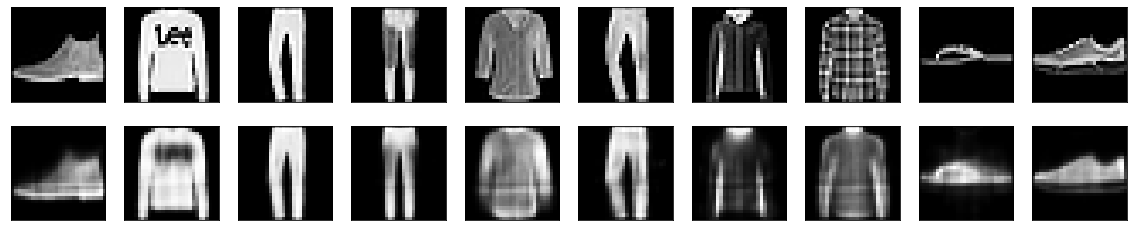

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder = Autoencoder(x_train.shape[1],32)
autoencoder.train(x_train, x_test, 256, 50)
encoded_imgs = autoencoder.getEncodedImage(x_test)
decoded_imgs = autoencoder.getDecodedImage(encoded_imgs)

plt.figure(figsize=(20,4))

for i in range(10):
    # Original
    subplot = plt.subplot(2,10, i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
    
    # Reconstruction
    subplot = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
    
plt.show()

In [6]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

class Autoencoder(object):
    
    def __init__(self):    
        
        # Encoding
        input_layer = Input(shape=(28, 28, 1)) 
        encoding_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
        encoding_pooling_layer_1 = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_1)
        encoding_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoding_pooling_layer_1)
        encoding_pooling_layer_2 = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_2)
        encoding_conv_layer_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoding_pooling_layer_2)
        code_layer = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_3)
        
        # Decoding
        decodging_conv_layer_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(code_layer)
        decodging_upsampling_layer_1 = UpSampling2D((2, 2))(decodging_conv_layer_1)
        decodging_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(decodging_upsampling_layer_1)
        decodging_upsampling_layer_2 = UpSampling2D((2, 2))(decodging_conv_layer_2)
        decodging_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')(decodging_upsampling_layer_2)
        decodging_upsampling_layer_3 = UpSampling2D((2, 2))(decodging_conv_layer_3)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decodging_upsampling_layer_3)
        
        self._model = Model(input_layer, output_layer)
        self._model.compile(optimizer='adadelta', loss='binary_crossentropy')
        
    def train(self, input_train, input_test, batch_size, epochs):    
        self._model.fit(input_train, 
                        input_train,
                        epochs = epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(
                                input_test, 
                                input_test))
        
    
    def getDecodedImage(self, encoded_imgs):
        decoded_image = self._model.predict(encoded_imgs)
        return decoded_image

Epoch 1/50
235/235 [==============================] - 2s 8ms/step - loss: 0.6949 - val_loss: 0.6946
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6942 - val_loss: 0.6939
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6935 - val_loss: 0.6932
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6928 - val_loss: 0.6924
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6920 - val_loss: 0.6916
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6911 - val_loss: 0.6906
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6901 - val_loss: 0.6895
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6889 - val_loss: 0.6882
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6874 - val_loss: 0.6866
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6857 - val_loss: 0.6847

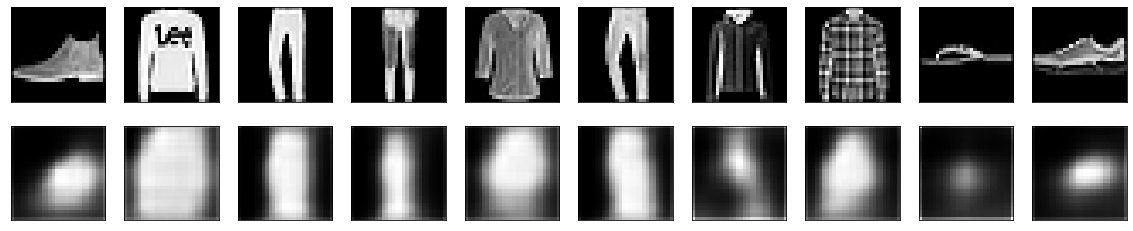

In [7]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Prepare input
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Convolutional implementation
autoencoder = Autoencoder()
autoencoder.train(x_train, x_test, 256, 50)
decoded_imgs = autoencoder.getDecodedImage(x_test)

# Convolutional implementation results
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    subplot = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)

    # Reconstruction
    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()